# 1. Configuración del Entorno e Importaciones

Preparamos el entorno, importando las librerías necesarias y configurando la ruta para acceder a nuestros módulos de registro (`src/`). Esto asegura la conexión para la detección de características, el emparejamiento y el cálculo de homografía.

In [5]:
# Importar librerias
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import sys
import glob
import math

In [2]:
# --- Configuración de Rutas ---
# Agregamos el directorio raíz del proyecto al path de Python
project_root = os.path.abspath(os.path.join('..'))
if project_root not in sys.path:
    sys.path.append(project_root)

# Importar módulos propios desarrollados en src/
from src import feature_detection, matching, registration, utils

# Configuración visual para las gráficas
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['image.cmap'] = 'gray'

print(f"✅ Librerías importadas. Directorio raíz: {project_root}")

✅ Librerías importadas. Directorio raíz: d:\Inteligencia Artificial\Semestre II\Vision por computador\Practica_2\proyecto_registro_imagenes


# 2. Generación de Datos Sintéticos (Ground Truth)

Para validar nuestro algoritmo de registro, necesitamos conocer la "respuesta correcta". En este paso:
1. Tomamos todas las imágenes originales de `data/original`.
2. Aplicamos transformaciones conocidas: **Rotación** (10°), **Escala** (1.2x) y **Traslación**.
3. Guardamos la nueva imagen y la **matriz de transformación real** (`_H.npy`) en `data/synthetic`.

Esto nos permitirá comparar luego si nuestro código calcula la homografía correctamente.

In [3]:
original_dir = os.path.join(project_root, 'data', 'original')
synthetic_dir = os.path.join(project_root, 'data', 'synthetic')

# Validar directorios
if not os.path.exists(synthetic_dir):
    os.makedirs(synthetic_dir)

# Buscar imágenes originales válidas
valid_exts = ('.jpg', '.jpeg', '.png')
imagenes_originales = [f for f in os.listdir(original_dir) if f.lower().endswith(valid_exts)]

print(f"🔄 Generando datos sintéticos para {len(imagenes_originales)} imágenes base...\n")

count = 0
for img_name in imagenes_originales:
    img_path = os.path.join(original_dir, img_name)
    image = cv2.imread(img_path)

    if image is not None:
        # Llama a la función en src/utils.py que aplica las deformaciones
        utils.save_synthetic_data(img_name, image, synthetic_dir)
        count += 1
    else:
        print(f"⚠️ Error al leer: {img_name}")

print(f"✅ ¡Generación completada! Se procesaron {count} imágenes base.")
print(f"📂 Los datos de prueba están en: {synthetic_dir}")

🔄 Generando datos sintéticos para 3 imágenes base...

--- Generando sintéticos para IMG01.jpg ---
Generado: IMG01_rot10.jpg
Matriz guardada en: IMG01_rot10_H.npy
Generado: IMG01_scale1.2.jpg
Matriz guardada en: IMG01_scale1.2_H.npy
Generado: IMG01_trans.jpg
Matriz guardada en: IMG01_trans_H.npy
Generado: IMG01_mix.jpg
Matriz guardada en: IMG01_mix_H.npy
--- Generando sintéticos para IMG02.jpg ---
Generado: IMG02_rot10.jpg
Matriz guardada en: IMG02_rot10_H.npy
Generado: IMG02_scale1.2.jpg
Matriz guardada en: IMG02_scale1.2_H.npy
Generado: IMG02_trans.jpg
Matriz guardada en: IMG02_trans_H.npy
Generado: IMG02_mix.jpg
Matriz guardada en: IMG02_mix_H.npy
--- Generando sintéticos para IMG03.jpg ---
Generado: IMG03_rot10.jpg
Matriz guardada en: IMG03_rot10_H.npy
Generado: IMG03_scale1.2.jpg
Matriz guardada en: IMG03_scale1.2_H.npy
Generado: IMG03_trans.jpg
Matriz guardada en: IMG03_trans_H.npy
Generado: IMG03_mix.jpg
Matriz guardada en: IMG03_mix_H.npy
✅ ¡Generación completada! Se procesaron 

# 3. Visualización de Datos Sintéticos

Antes de proceder con la validación matemática, es crucial realizar una **inspección visual** para confirmar que las imágenes se generaron correctamente. En este paso:

1. Tomamos las imágenes creadas en la carpeta `data/synthetic`.
2. Extraemos el tipo de transformación para usarlo como etiqueta.
3. Desplegamos una **cuadrícula de visualización** con títulos descriptivos.

Este *sanity check* nos asegura que las deformaciones (**Rotación**, **Escala**, **Traslación**) son coherentes y que el dataset es válido para las pruebas de registro.


👁️ Visualizando 12 imágenes sintéticas con sus transformaciones:


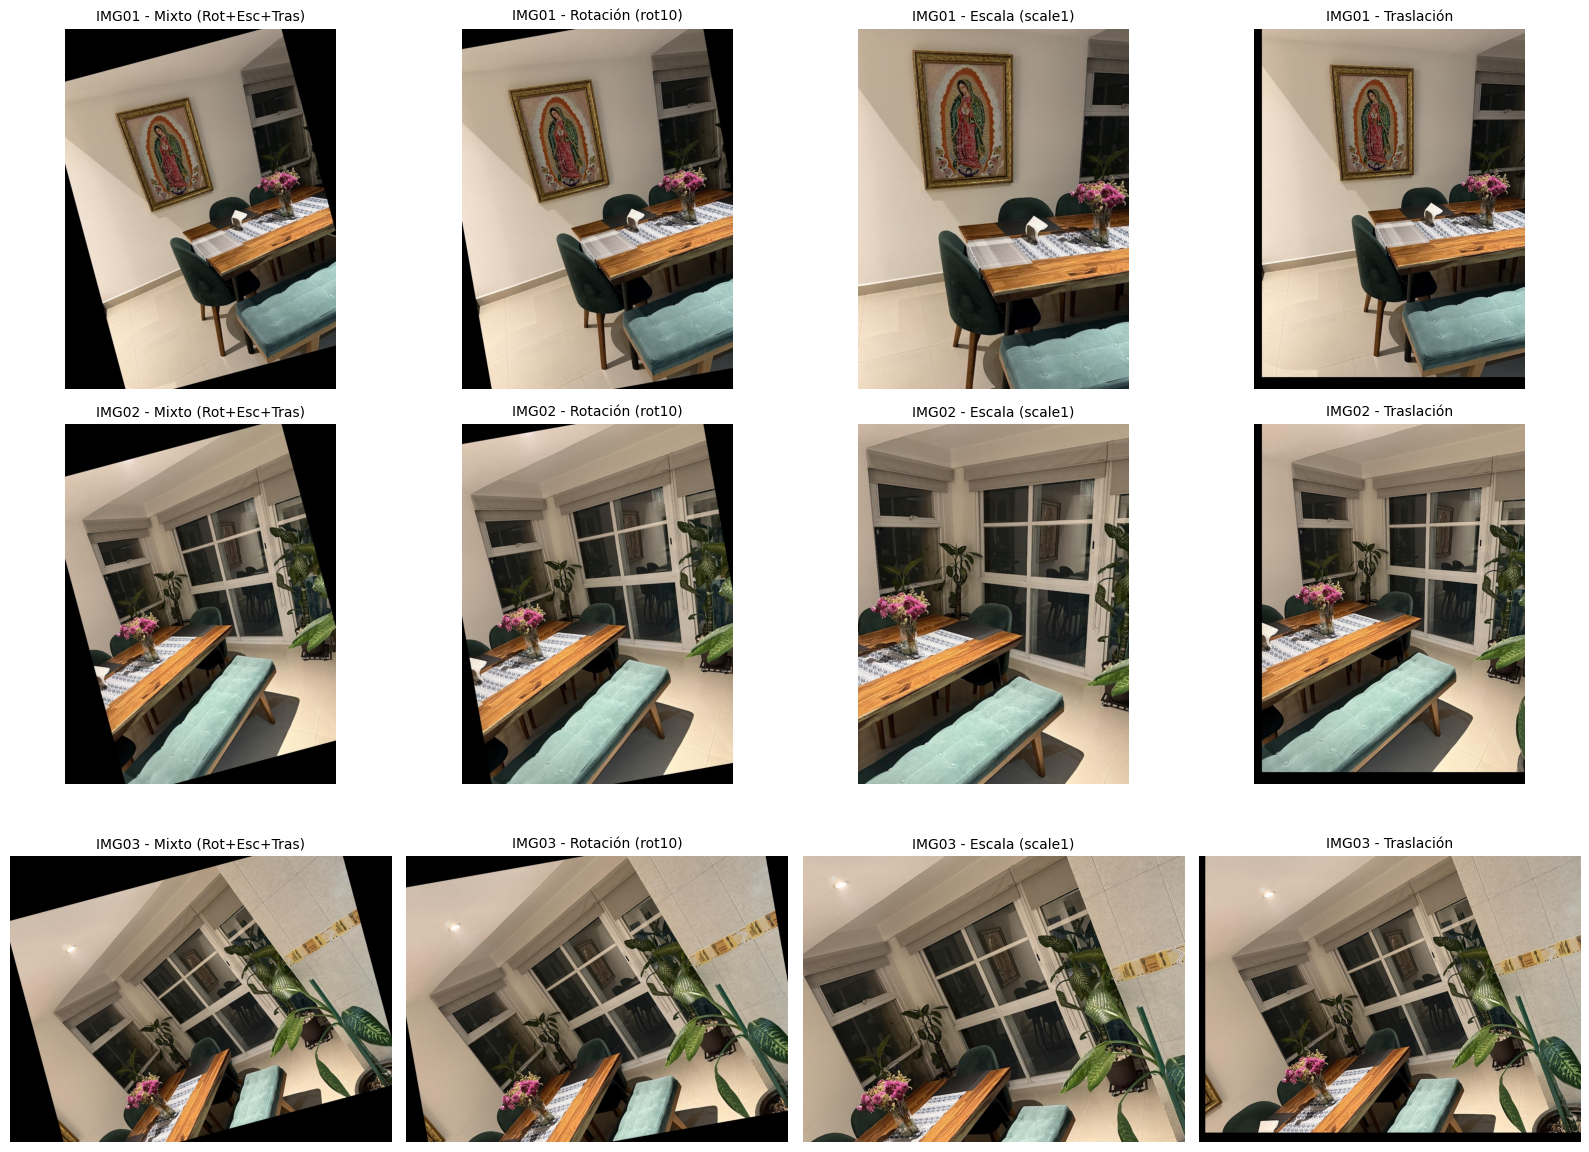

In [8]:
# --- Visualización de Datos Sintéticos con Títulos Descriptivos ---
# 1. Buscar las imágenes generadas
patron_busqueda = os.path.join(synthetic_dir, "*.jpg")
archivos_sinteticos = glob.glob(patron_busqueda)
archivos_sinteticos.sort() # Ordenar

num_imagenes = len(archivos_sinteticos)

if num_imagenes > 0:
    print(f"\n👁️ Visualizando {num_imagenes} imágenes sintéticas con sus transformaciones:")
    
    # 2. Configurar cuadrícula
    cols = 4
    rows = math.ceil(num_imagenes / cols)
    
    plt.figure(figsize=(16, 4 * rows))
    
    for i, file_path in enumerate(archivos_sinteticos):
        img = cv2.imread(file_path)
        
        if img is not None:
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            plt.subplot(rows, cols, i + 1)
            plt.imshow(img_rgb)
            
            # --- LÓGICA PARA EL TÍTULO ---
            # Extraemos el nombre: "IMG01_rot10.jpg" -> "IMG01_rot10"
            nombre_base = os.path.basename(file_path).split('.')[0]
            
            # Separamos por el guion bajo '_' para obtener el sufijo
            partes = nombre_base.split('_')
            sufijo = partes[-1] if len(partes) > 1 else "Original"
            
            # Asignamos un título más legible según el sufijo
            if "rot" in sufijo:
                titulo = f"Rotación ({sufijo})"
            elif "scale" in sufijo:
                titulo = f"Escala ({sufijo})"
            elif "trans" in sufijo:
                titulo = "Traslación"
            elif "mix" in sufijo:
                titulo = "Mixto (Rot+Esc+Tras)"
            else:
                titulo = sufijo # Por si acaso es otro nombre
            
            plt.title(f"{partes[0]} - {titulo}", fontsize=10)
            plt.axis('off')

    plt.tight_layout()
    plt.show()
else:
    print(f"⚠️ No se encontraron imágenes en: {synthetic_dir}")

# 3. Definición del Pipeline de Validación

Aquí definimos la función `validar_transformacion`. Esta función simula el proceso real de registro:
1. **Detección:** Extrae puntos clave (Keypoints) usando SIFT.
2. **Matching:** Busca correspondencias entre la imagen original y la sintética.
3. **Homografía:** Calcula la matriz de transformación usando RANSAC para filtrar errores.
4. **Cálculo de Error:** Compara la matriz calculada con la matriz real (Ground Truth) usando el error RMSE (Root Mean Square Error).

In [4]:
def validar_transformacion(img_original, img_sintetica_path, H_ground_truth):
    """
    Intenta recuperar la transformación entre la original y la sintética
    y compara el resultado con la matriz verdadera.
    """
    img_syn = cv2.imread(img_sintetica_path)
    if img_syn is None:
        return float('inf'), 0, None
    
    # 1. Detección de características (Usamos SIFT para la validación por ser más robusto)
    kp_orig, desc_orig = feature_detection.detect_features(img_original, method='SIFT')
    kp_syn, desc_syn = feature_detection.detect_features(img_syn, method='SIFT')
    
    # 2. Emparejamiento (Matching) con Ratio Test de Lowe
    matches = matching.match_features(desc_orig, desc_syn, method='SIFT', ratio_thresh=0.75)
    
    # 3. Estimación de Homografía (RANSAC)
    # Nota: RANSAC es vital para ignorar emparejamientos incorrectos
    H_estimada, mask = registration.estimate_homography(kp_orig, kp_syn, matches)
    
    # 4. Cálculo del Error (RMSE)
    error_rmse = registration.calculate_transform_error(H_estimada, H_ground_truth)
    
    return error_rmse, len(matches), img_syn

# 4. Ejecución de la Validación Cruzada

Iteramos sobre cada imagen generada en `data/synthetic`. Para cada una:
1. Buscamos su imagen "madre" original.
2. Ejecutamos el pipeline de validación.
3. Evaluamos si el error es aceptable (RMSE < 3.0).

Los resultados se almacenan en una tabla de **Pandas** para facilitar el análisis de robustez.

In [5]:
resultados = []

print("Iniciando validación del algoritmo...\n")

# Iterar sobre cada imagen original para validar sus variaciones
for img_base_name in imagenes_originales:
    path_base = os.path.join(original_dir, img_base_name)
    img_base = cv2.imread(path_base)
    
    if img_base is None: continue

    # Nombre sin extensión (ej: IMG01)
    nombre_raiz = os.path.splitext(img_base_name)[0]
    
    # Buscar todas las variantes sintéticas de ESTA imagen específica
    patron_busqueda = os.path.join(synthetic_dir, f"{nombre_raiz}_*.jpg")
    archivos_prueba = glob.glob(patron_busqueda)
    
    for path_prueba in archivos_prueba:
        nombre_prueba = os.path.basename(path_prueba)
        
        # Buscar la matriz de verdad (.npy) asociada
        path_matriz = path_prueba.replace('.jpg', '_H.npy')
        
        if os.path.exists(path_matriz):
            H_true = np.load(path_matriz)
            
            # --- EJECUTAR PRUEBA ---
            rmse, n_matches, _ = validar_transformacion(img_base, path_prueba, H_true)
            
            # Criterio de éxito: Un error RMSE bajo (< 3.0 píxeles promedios) indica éxito
            estado = "✅ Pasa" if rmse < 3.0 else "⚠️ Falló"
            
            # Extraer el tipo de prueba del nombre (ej: rot10, scale1.2) para el reporte
            tipo_prueba = nombre_prueba.replace(nombre_raiz + "_", "").replace(".jpg", "")
            
            resultados.append({
                "Imagen Base": img_base_name,
                "Experimento": tipo_prueba,
                "Matches": n_matches,
                "RMSE (Error)": round(rmse, 4),
                "Estado": estado
            })

# Crear Tabla de Resultados
df_resultados = pd.DataFrame(resultados)

# Ordenar: primero los errores, luego los éxitos
df_resultados = df_resultados.sort_values(by="RMSE (Error)", ascending=False)

print(f"📊 Resumen de Validación ({len(resultados)} pruebas realizadas):")
display(df_resultados)

Iniciando validación del algoritmo...

📊 Resumen de Validación (12 pruebas realizadas):


,Imagen Base,Experimento,Matches,RMSE (Error),Estado
4,IMG02.jpg,mix,781,0.0829,✅ Pasa
6,IMG02.jpg,scale1.2,771,0.0621,✅ Pasa
5,IMG02.jpg,rot10,949,0.0580,✅ Pasa
2,IMG01.jpg,scale1.2,787,0.0509,✅ Pasa
0,IMG01.jpg,mix,655,0.0479,✅ Pasa
8,IMG03.jpg,mix,1625,0.0302,✅ Pasa
10,IMG03.jpg,scale1.2,1550,0.0267,✅ Pasa
11,IMG03.jpg,trans,2672,0.0226,✅ Pasa
1,IMG01.jpg,rot10,850,0.0212,✅ Pasa
9,IMG03.jpg,rot10,1948,0.0194,✅ Pasa


# 5. Visualización de Matches (Inliers)

Finalmente, visualizamos uno de los casos exitosos. Dibujamos las líneas que conectan los puntos coincidentes entre la imagen original y la sintética transformada.
* Si las líneas son paralelas o siguen un patrón coherente, el matching es correcto.
* Si hay muchas líneas cruzadas caóticamente, el registro falló.

👁️ Visualizando caso exitoso: IMG01.jpg - trans


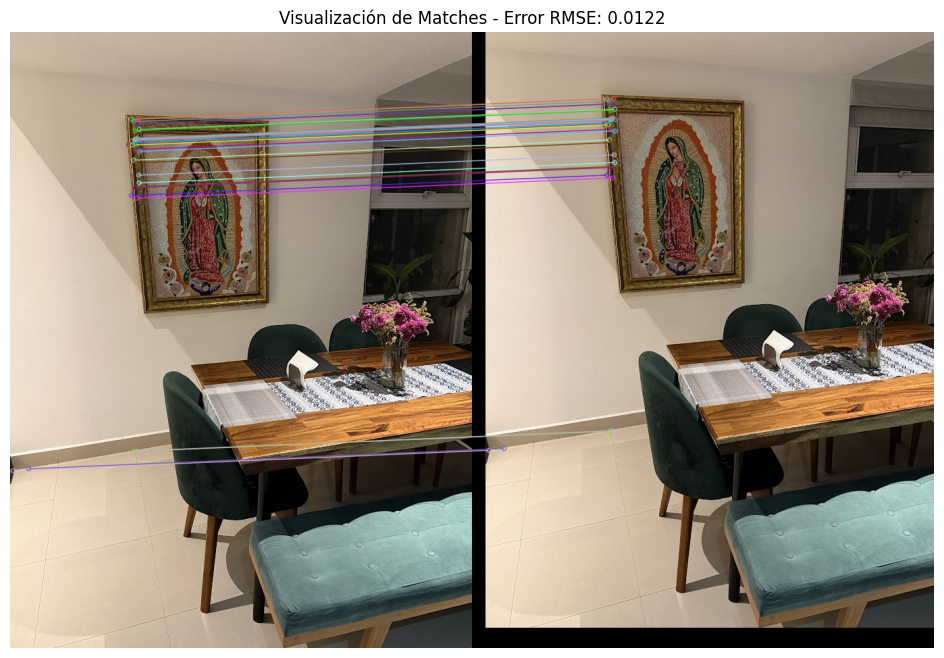

In [6]:
# Tomar el mejor resultado (menor error) para visualizar
if not df_resultados.empty:
    # Seleccionamos el último de la lista (porque ordenamos descendente por error)
    mejor_caso = df_resultados.iloc[-1] 
    
    print(f"👁️ Visualizando caso exitoso: {mejor_caso['Imagen Base']} - {mejor_caso['Experimento']}")
    
    # Recargar imágenes para pintar
    img_orig_path = os.path.join(original_dir, mejor_caso['Imagen Base'])
    img_syn_name = f"{os.path.splitext(mejor_caso['Imagen Base'])[0]}_{mejor_caso['Experimento']}.jpg"
    img_syn_path = os.path.join(synthetic_dir, img_syn_name)
    
    img1 = cv2.imread(img_orig_path)
    img2 = cv2.imread(img_syn_path)
    
    # Recalcular matches solo para dibujar
    kp1, d1 = feature_detection.detect_features(img1, 'SIFT')
    kp2, d2 = feature_detection.detect_features(img2, 'SIFT')
    matches = matching.match_features(d1, d2, 'SIFT', 0.75)
    
    # Dibujar matches (limitado a 30 para que no sature la imagen)
    img_matches = cv2.drawMatches(img1, kp1, img2, kp2, matches[:30], None, flags=2)
    
    plt.figure(figsize=(15, 8))
    plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
    plt.title(f"Visualización de Matches - Error RMSE: {mejor_caso['RMSE (Error)']}")
    plt.axis('off')
    plt.show()
else:
    print("No hay resultados suficientes para visualizar.")